In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])
tau_rc_in, delay_rc_in = itemgetter("tau", "delay")(params["relay"]["Krc_in"])

w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
tau_rc_ex_small, tau_rc_ex_large = itemgetter("tau_small", "tau_large")(params["relay"]["Krc_ex"])
delay_rc_ex_small, delay_rc_ex_large = itemgetter("delay_small", "delay_large")(params["relay"]["Krc_ex"])

irf_attrs = {"fast_short": {}, "fast_long": {}, "delayed_short": {}, "delayed_long": {}}

## Feedforward excitation

In [2]:
network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                        A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                        phase=phase, damping=damping, delay_g=delay_g,
                                        w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                        tau_rg=tau_rg, delay_rg=delay_rg)

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)
Nr = network.integrator.Nr
temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
t_peak, I_bp = temporal_irf_params(temporal_irf, network.integrator.times)

t_peak = float(t_peak.rescale("ms").magnitude)
I_bp = float(I_bp.magnitude)

irf_attrs["ff_ex"] = {"irf": temporal_irf, "t_peak": t_peak, "I_bp": I_bp}

## 1. Fast and short-lasting excitatory feedback

In [3]:
t_peak = np.zeros([len(delay_rc_in), len(tau_rc_in)]) * pq.ms
I_bp = np.zeros([len(delay_rc_in), len(tau_rc_in)])
irf = np.zeros([2**nt, len(delay_rc_in), len(tau_rc_in)])

for i, delay in enumerate(delay_rc_in):
    for j, tau in enumerate(tau_rc_in):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rc_in=w_rc_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau, delay_rc_in=delay,
                                                w_rc_ex=w_rc_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau_rc_ex_small, delay_rc_ex=delay_rc_ex_small)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        Nr = network.integrator.Nr
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_attrs["fast_short"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

## 2. Fast and long-lasting excitatory feedback

In [4]:
t_peak = np.zeros([len(delay_rc_in), len(tau_rc_in)]) * pq.ms
I_bp = np.zeros([len(delay_rc_in), len(tau_rc_in)])
irf = np.zeros([2**nt, len(delay_rc_in), len(tau_rc_in)])

for i, delay in enumerate(delay_rc_in):
    for j, tau in enumerate(tau_rc_in):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rc_in=w_rc_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau, delay_rc_in=delay,
                                                w_rc_ex=w_rc_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau_rc_ex_large, delay_rc_ex=delay_rc_ex_small)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        Nr = network.integrator.Nr
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_attrs["fast_long"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

## 3. Delayed and short-lasting excitatory feedback

In [5]:
t_peak = np.zeros([len(delay_rc_in), len(tau_rc_in)]) * pq.ms
I_bp = np.zeros([len(delay_rc_in), len(tau_rc_in)])
irf = np.zeros([2**nt, len(delay_rc_in), len(tau_rc_in)])

for i, delay in enumerate(delay_rc_in):
    for j, tau in enumerate(tau_rc_in):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rc_in=w_rc_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau, delay_rc_in=delay,
                                                w_rc_ex=w_rc_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau_rc_ex_small, delay_rc_ex=delay_rc_ex_large)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        Nr = network.integrator.Nr
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        

irf_attrs["delayed_short"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

## 4. Delayed and long-lasting excitatory feedback

In [6]:
t_peak = np.zeros([len(delay_rc_in), len(tau_rc_in)]) * pq.ms
I_bp = np.zeros([len(delay_rc_in), len(tau_rc_in)])
irf = np.zeros([2**nt, len(delay_rc_in), len(tau_rc_in)])

for i, delay in enumerate(delay_rc_in):
    for j, tau in enumerate(tau_rc_in):
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rc_in=w_rc_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                tau_rc_in=tau, delay_rc_in=delay,
                                                w_rc_ex=w_rc_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                tau_rc_ex=tau_rc_ex_large, delay_rc_ex=delay_rc_ex_large)
        [relay] = get_neuron("Relay", network)
        network.compute_irf(relay)
        Nr = network.integrator.Nr
        temporal_irf = relay.irf[:, int(Nr/2), int(Nr/2)]
        irf[:, i, j] = temporal_irf
        t_peak[i, j], I_bp[i, j] = temporal_irf_params(temporal_irf, network.integrator.times)
        
irf_attrs["delayed_long"] = {"irf": irf, "t_peak": t_peak, "I_bp": I_bp}

-------------
## Plotting

### Settings

In [7]:
cmap = "RdBu_r"
interpolation = "none"
color = "gray"
alpha = 0.6

# line plots:
t_max = 200
ymin = -0.5
ymax = 0.9
times = network.integrator.times
tau_ids = [0, int(len(tau_rc_in)/2 - 1), -1]

# imshow plots:
t_peak_vmin = 0.9
t_peak_vmax = 1.1
t_peak_levels = np.array([25, 40]) / irf_attrs["ff_ex"]["t_peak"]

I_bp_vmin = 0.5
I_bp_vmax = 2.0
I_bp_levels = np.array([0.2, 0.6]) / irf_attrs["ff_ex"]["I_bp"]

extent = [float(tau_rc_in.min().magnitude), float(tau_rc_in.max().magnitude), 
          float(delay_rc_in.min().magnitude), float(delay_rc_in.max().magnitude)]


# figure grid
fig = plt.figure(figsize=(8, 11))

# line plots
gs1 = gridspec.GridSpec(8, 2)
gs1.update(left=0.05, right=0.45, hspace=3, wspace=0.05)

ax_1 = plt.subplot(gs1[:2, 0])
ax_2 = plt.subplot(gs1[:2, 1])
ax_5 = plt.subplot(gs1[2:4, 0])
ax_6 = plt.subplot(gs1[2:4, 1])
ax_9 = plt.subplot(gs1[4:6, 0])
ax_10 = plt.subplot(gs1[4:6, 1])
ax_13 = plt.subplot(gs1[6:8, 0])
ax_14 = plt.subplot(gs1[6:8, 1])

# imshow plots
gs2 = gridspec.GridSpec(8, 2)
gs2.update(left=0.55, right=0.98, hspace=3, wspace=0.15)

ax_3 = plt.subplot(gs2[:2, 0])
ax_4 = plt.subplot(gs2[:2, 1])
ax_7 = plt.subplot(gs2[2:4, 0])
ax_8 = plt.subplot(gs2[2:4, 1])
ax_11 = plt.subplot(gs2[4:6, 0])
ax_12 = plt.subplot(gs2[4:6, 1])
ax_15 = plt.subplot(gs2[6:8, 0])
ax_16 = plt.subplot(gs2[6:8, 1])


# titles:

titles = ["Fast and short-lasting\n", "Fast and long-lasting\n", 
          "Delayed and short-lasting\n", "Delayed and long-lasting\n"]

for (tau, delay), y_pos, title in zip([[delay_rc_ex_small,tau_rc_ex_small],
                                       [delay_rc_ex_small, tau_rc_ex_large],
                                       [delay_rc_ex_large,tau_rc_ex_small],
                                       [delay_rc_ex_large, tau_rc_ex_large]],
                                       [0.94, 0.70, 0.49, 0.29], titles):

    tau, delay = tau.magnitude, delay.magnitude
    full_title = title + (r"$\Delta^\mathrm{{ex}}_\mathrm{{RCR}}= {}\;\mathrm{{ms}},"
                        r"\; \tau^\mathrm{{ex}}_\mathrm{{RCR}} = {}\;\mathrm{{ms}}$".format(tau, delay))
    plt.figtext(0.5, y_pos, full_title, ha='center', va='center', fontsize=18, linespacing=1.5)
    
plt.close()

### Create figure

In [8]:
for ax_row, irf_attr in zip([[ax_1, ax_2, ax_3, ax_4],
                             [ax_5, ax_6, ax_7, ax_8],
                             [ax_9, ax_10, ax_11, ax_12],
                             [ax_13, ax_14, ax_15, ax_16]], 
                            [irf_attrs["fast_short"], 
                             irf_attrs["fast_long"], 
                             irf_attrs["delayed_short"],
                             irf_attrs["delayed_long"]]):


    ax1, ax2, ax3, ax4 = ax_row
    
    # line plots
    for ax, delay_id in zip([ax1, ax2], [0, -1]):
        ax.plot(times, irf_attrs["ff_ex"]["irf"], color='k', linestyle="--")
        ax.set_ylim([ymin, ymax])
        ax.set_xlim([0, t_max])
        
        for tau_id in tau_ids:
            tau = round(float(tau_rc_in[tau_id].magnitude), 1)
            ax.plot(times, irf_attr["irf"][:, delay_id, tau_id],
                    label=r"$\tau_\mathrm{{RCR}}^\mathrm{{in}}{{=}}{}\mathrm{{ms}}$".format(tau))
    

    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    if not ax1 == ax_13:
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    
    # t_peak plot
    t_peak = irf_attr["t_peak"].rescale("ms") / irf_attrs["ff_ex"]["t_peak"]
    im1 = ax3.imshow(t_peak, aspect="auto", origin="lower", cmap=cmap, extent=extent, 
                     interpolation=interpolation, vmin=t_peak_vmin, vmax=t_peak_vmax, 
                     norm=MidpointNormalize(midpoint=1.))

    t_peak_mask = np.where((t_peak >= t_peak_levels[0]) & (t_peak <= t_peak_levels[-1]), 0, 1)
    ax3.contourf(t_peak_mask, extent=extent, levels=t_peak_levels, colors=color, alpha=alpha)
    
    plt.colorbar(im1, ax=ax3, ticks=[t_peak_vmin, 1, t_peak_vmax])
    ax3.grid(False)  
    if not ax3 == ax_15:
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])

    
    # Biphasic index plot
    I_bp = irf_attr["I_bp"] / irf_attrs["ff_ex"]["I_bp"]
    im2 = ax4.imshow(I_bp, aspect="auto", origin="lower", cmap=cmap, extent=extent, 
                     interpolation=interpolation, vmin=I_bp_vmin, vmax=I_bp_vmax, 
                     norm=MidpointNormalize(midpoint=1.))

    I_bp_mask = np.where((I_bp  >= I_bp_levels[0]) & (I_bp  <= I_bp_levels[-1]), 0, 1)
    ax4.contourf(I_bp_mask, extent=extent, levels=I_bp_levels, colors=color, alpha=alpha)
    
    plt.colorbar(im2, ax=ax4, ticks=[I_bp_vmin, 1, I_bp_vmax])
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    ax4.grid(False)


ax_3.set_title(r"$t_\mathrm{peak}$")
ax_4.set_title("Biphasic index")
ax_15.set_ylabel(r"$\Delta_\mathrm{RCR}^\mathrm{in}\; (\mathrm{ms})$")
ax_15.set_xlabel(r"$\tau_\mathrm{RCR}^\mathrm{in}\; (\mathrm{ms})$")
ax_1.set_title(r"$\Delta_\mathrm{{RCR}}^\mathrm{{in}}={}\;\mathrm{{ms}}$".format(round(delay_rc_in[0], 1).magnitude))
ax_2.set_title(r"$\Delta_\mathrm{{RCR}}^\mathrm{{in}}={}\;\mathrm{{ms}}$".format(round(delay_rc_in[-1], 1).magnitude))

ax_13.set_xlabel("Time (ms)")
ax_13.set_ylabel("Response")
ax_13.legend(fontsize=14, handlelength=0.3, labelspacing=0.2, borderpad=0.0, 
             borderaxespad=0.0, handletextpad=0.05)

plt.close()

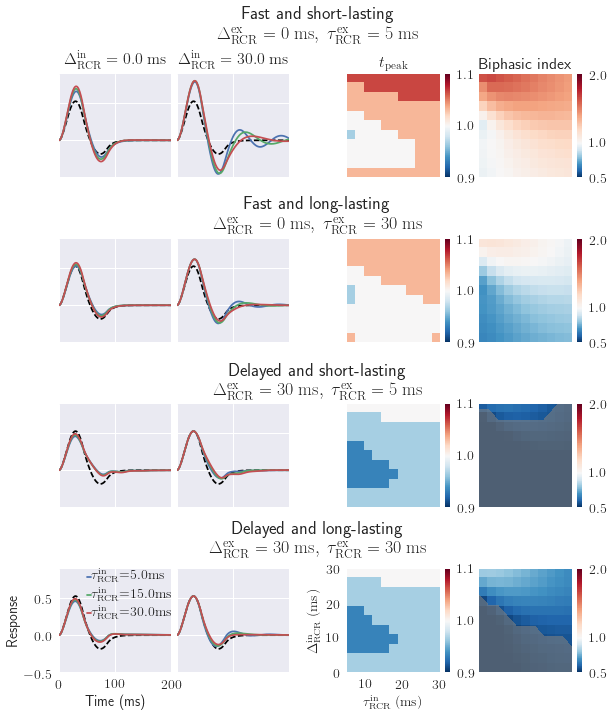

In [9]:
fig